In [1]:
# import library
import time
import math
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import yfinance as yf


yf.pdr_override()


import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Data

In [2]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

# Set up End and Start times(5 years) for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2018-11-23,43.735001,44.150002,43.025002,43.072498,41.341454,94496000,APPLE
2018-11-26,43.560001,43.737499,42.564999,43.654999,41.900558,179994000,APPLE
2018-11-27,42.877499,43.692501,42.720001,43.560001,41.809372,165549600,APPLE
2018-11-28,44.182499,45.322498,43.732498,45.235001,43.417061,184250000,APPLE
2018-11-29,45.665001,45.700001,44.424999,44.887501,43.083515,167080000,APPLE
...,...,...,...,...,...,...,...
2023-11-15,187.850006,189.500000,187.779999,188.009995,188.009995,53790500,APPLE
2023-11-16,189.570007,190.960007,188.649994,189.710007,189.710007,54412900,APPLE
2023-11-17,190.250000,190.380005,188.570007,189.690002,189.690002,50922700,APPLE


In [3]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-11-23 to 2023-11-21
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1257 non-null   float64
 1   High          1257 non-null   float64
 2   Low           1257 non-null   float64
 3   Close         1257 non-null   float64
 4   Adj Close     1257 non-null   float64
 5   Volume        1257 non-null   int64  
 6   company_name  1257 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.6+ KB


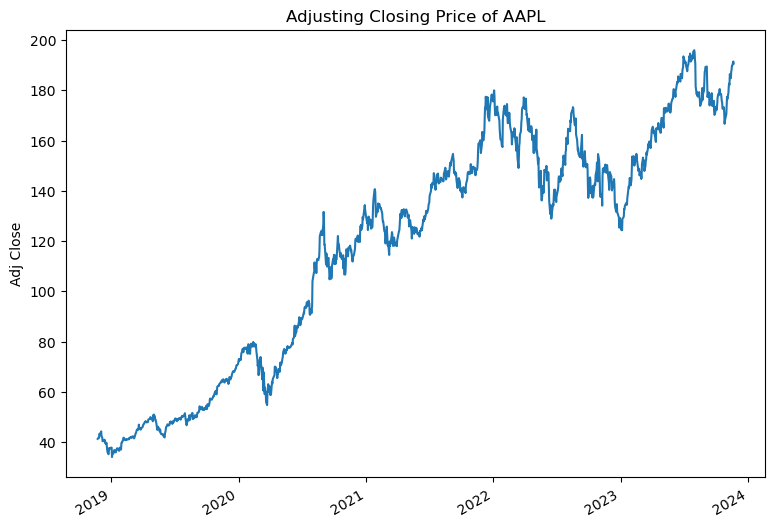

In [4]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 10))
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Adjusting Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()
plt.savefig('adj_close_aapl.png')

In [5]:
for company in company_list:
    company['Daily Log Return'] = np.log(company['Adj Close']) - np.log(company['Adj Close'].shift(1))
    company['Cumulative Sum of Log Returns'] = company['Daily Log Return'].cumsum()

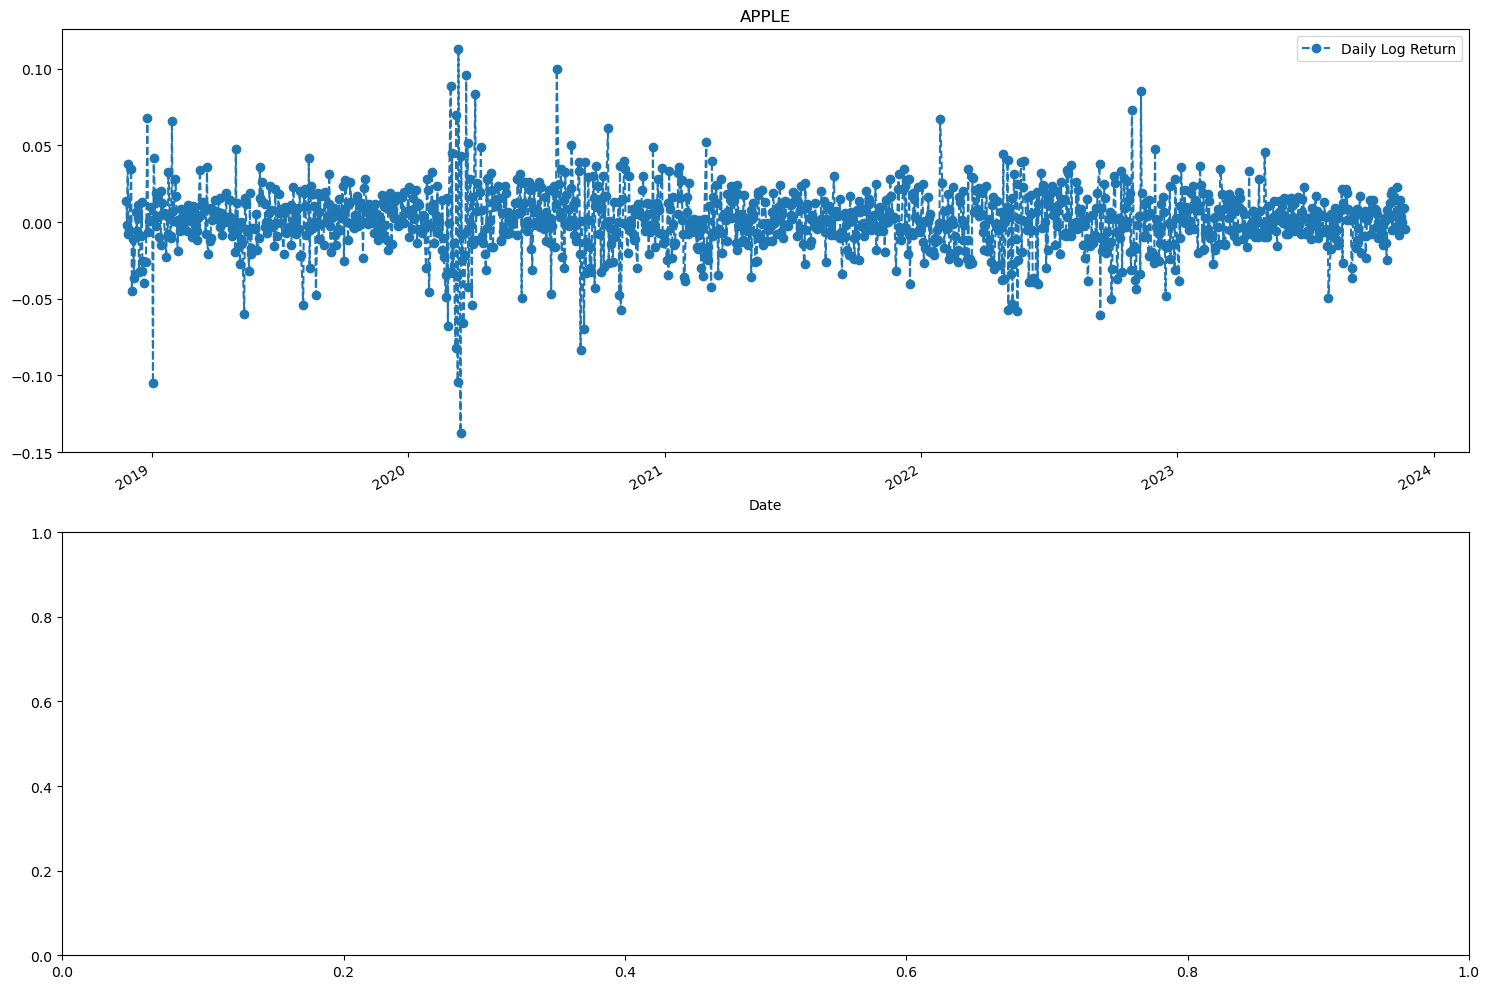

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Log Return'].plot(ax=axes[0], legend=True, linestyle='--', marker='o')

axes[0].set_title('APPLE')

fig.tight_layout()
plt.savefig('logreturn point.png')

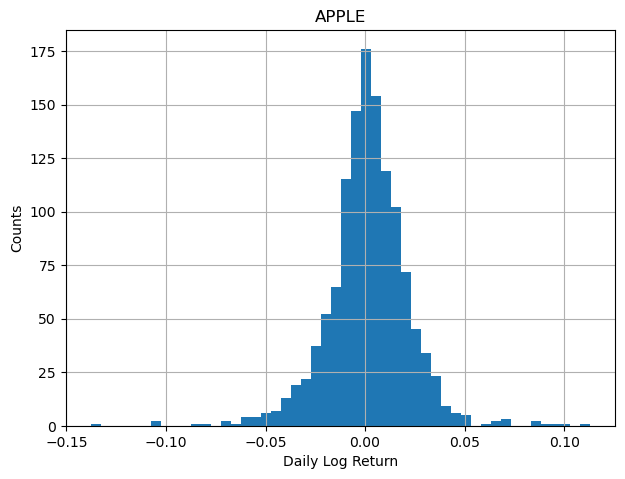

In [7]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Log Return'].hist(bins=50)
    plt.xlabel('Daily Log Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()
plt.savefig('logreturn_hist.png')

In [8]:
def input_data(series,T=10,D=1,test_ratio = 0.3):
    
    # Split into training, validation, and test sets
    test_length = int(len(series) * test_ratio)

    X = []
    Y = []
    for t in range(len(series)-T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)
    
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y).reshape(-1,1)
    N = len(X)
    
    test_length = int(N * test_ratio)
    train_length = N  - test_length
    
    X_train = torch.from_numpy(X[:-test_length].astype(np.float32))
    y_train = torch.from_numpy(Y[:-test_length].astype(np.float32))
    X_test = torch.from_numpy(X[-test_length:].astype(np.float32))
    y_test = torch.from_numpy(Y[-test_length:].astype(np.float32))
    
    print("X.shape", X.shape, "Y.shape", Y.shape)
    print("the length of the train set :", X_train.shape, len(X[:-test_length]))
    print("the length of the test set :", X_test.shape, len(X[-test_length:]))
    return X_train, y_train, X_test, y_test  

In [9]:
# Training

def full_gd(model,criterion,optimizer,X_train,y_train,X_test,y_test,epochs=100):
    
    start_time = time.time()
    
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Validation loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1) % 5 == 0:
            print(f"Epoch {it+1}/{epochs}, Train Loss:{loss.item():.4f}, Test Loss:{test_loss.item():.4f}")
            
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')        
    return train_losses, test_losses

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
class SimpleRNN(nn.Module):
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity = 'relu',
        batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self,X):
        
        # initial hidden states - L x N x M
        # L: the number of RNNlayers
        # N: the number of samples or the batchsize
        # M: the number of hidden features
        h0 = torch.zeros(self.L, X.size(0), self.M)
        
        # get RNN unit output
        # out is of size (N,T,M)
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:,-1,:])
        return out

## Window Size Fixing

#### T = 10

In [12]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 10, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1246, 10, 1) Y.shape (1246, 1)
the length of the train set : torch.Size([873, 10, 1]) 873
the length of the test set : torch.Size([373, 10, 1]) 373
Epoch 5/100, Train Loss:0.0006, Test Loss:0.0009
Epoch 10/100, Train Loss:0.0044, Test Loss:0.0036
Epoch 15/100, Train Loss:0.0009, Test Loss:0.0005
Epoch 20/100, Train Loss:0.0007, Test Loss:0.0006
Epoch 25/100, Train Loss:0.0009, Test Loss:0.0006
Epoch 30/100, Train Loss:0.0006, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0

In [13]:
# one-step forecast using true targets
test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,10,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 10-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 10-------------------------------------------
Test data RMSE:  0.01769787543945724
Test data MSE:  0.0003132147950705438
Test data MAE:  0.013117337857917527


#### T=20

In [14]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 20, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1236, 20, 1) Y.shape (1236, 1)
the length of the train set : torch.Size([866, 20, 1]) 866
the length of the test set : torch.Size([370, 20, 1]) 370
Epoch 5/100, Train Loss:0.0064, Test Loss:0.0054
Epoch 10/100, Train Loss:0.0013, Test Loss:0.0019
Epoch 15/100, Train Loss:0.0006, Test Loss:0.0003
Epoch 20/100, Train Loss:0.0012, Test Loss:0.0010
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0

In [15]:
# one-step forecast using true targets
test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,20,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 20-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 20-------------------------------------------
Test data RMSE:  0.01792568260046259
Test data MSE:  0.00032133009669252735
Test data MAE:  0.01333962568041406


#### T = 40

In [16]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 40, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1216, 40, 1) Y.shape (1216, 1)
the length of the train set : torch.Size([852, 40, 1]) 852
the length of the test set : torch.Size([364, 40, 1]) 364
Epoch 5/100, Train Loss:0.0066, Test Loss:0.0056
Epoch 10/100, Train Loss:0.0008, Test Loss:0.0012
Epoch 15/100, Train Loss:0.0018, Test Loss:0.0011
Epoch 20/100, Train Loss:0.0005, Test Loss:0.0006
Epoch 25/100, Train Loss:0.0009, Test Loss:0.0006
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0004, Test Loss:0

In [17]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,40,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 40-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 40-------------------------------------------
Test data RMSE:  0.017572607656631968
Test data MSE:  0.0003087965398539204
Test data MAE:  0.013104180210615556


#### T = 60

In [18]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 60, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1196, 60, 1) Y.shape (1196, 1)
the length of the train set : torch.Size([838, 60, 1]) 838
the length of the test set : torch.Size([358, 60, 1]) 358
Epoch 5/100, Train Loss:0.0011, Test Loss:0.0005
Epoch 10/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 15/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0

In [19]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 60-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 60-------------------------------------------
Test data RMSE:  0.017304622078290654
Test data MSE:  0.0002994499452724644
Test data MAE:  0.012911788528813889


window size = 60

## Simple RNN

In [20]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 60, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
count_parameters(rnn_model)

X.shape (1196, 60, 1) Y.shape (1196, 1)
the length of the train set : torch.Size([838, 60, 1]) 838
the length of the test set : torch.Size([358, 60, 1]) 358
    20
   400
    20
    20
    20
     1
______
   481


In [21]:
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0019, Test Loss:0.0076
Epoch 10/100, Train Loss:0.0059, Test Loss:0.0035
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0005
Epoch 20/100, Train Loss:0.0015, Test Loss:0.0014
Epoch 25/100, Train Loss:0.0011, Test Loss:0.0008
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0006, Test Loss:0.0005
Epoch 40/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


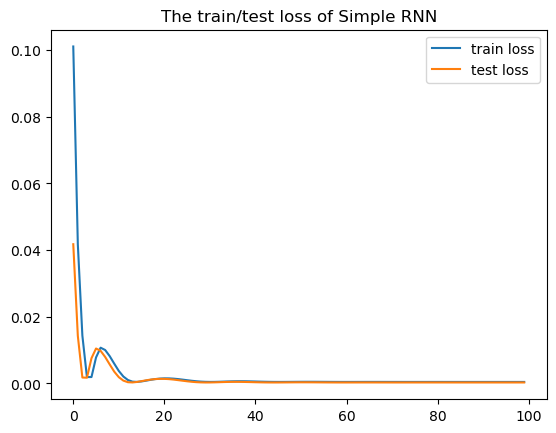

In [22]:
# Plot the train loss and calidation loss per iteration
plt.plot(rnn_train_losses, label="train loss")
plt.plot(rnn_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of Simple RNN")
plt.savefig('simplernn_loss.png')

In [23]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------Simple RNN -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------Simple RNN -------------------------------------------
Test data RMSE:  0.017187608785774376
Test data MSE:  0.0002954138957728285
Test data MAE:  0.012772313235025994


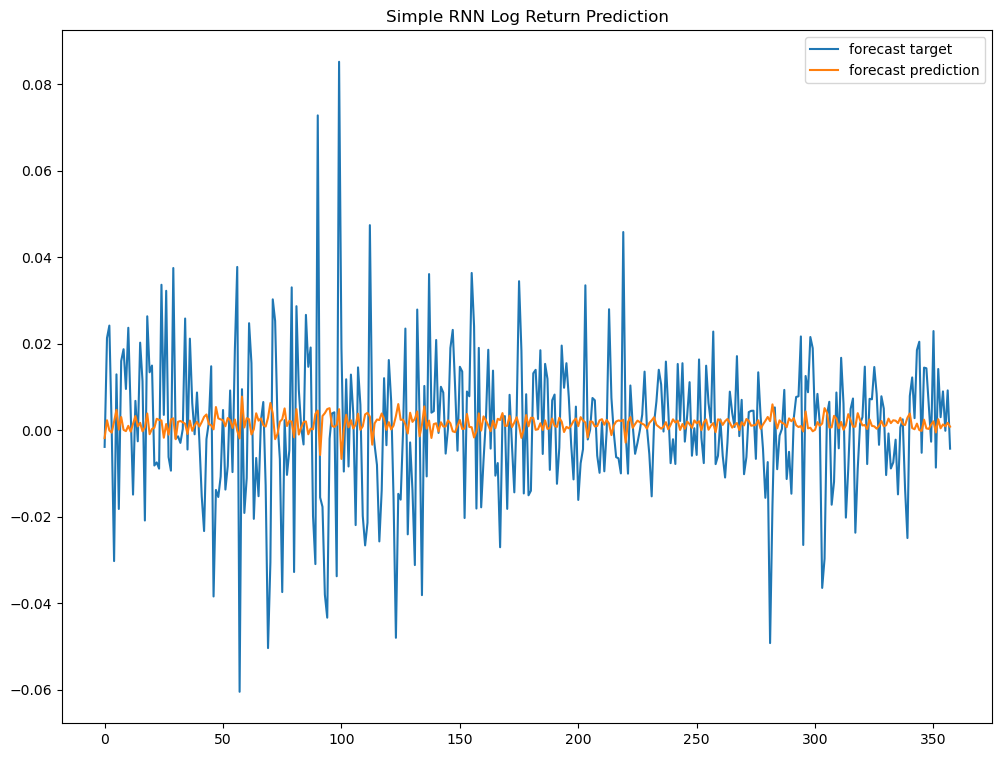

In [24]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("Simple RNN Log Return Prediction")
plt.savefig('Simple RNN Log Return Prediction.png')

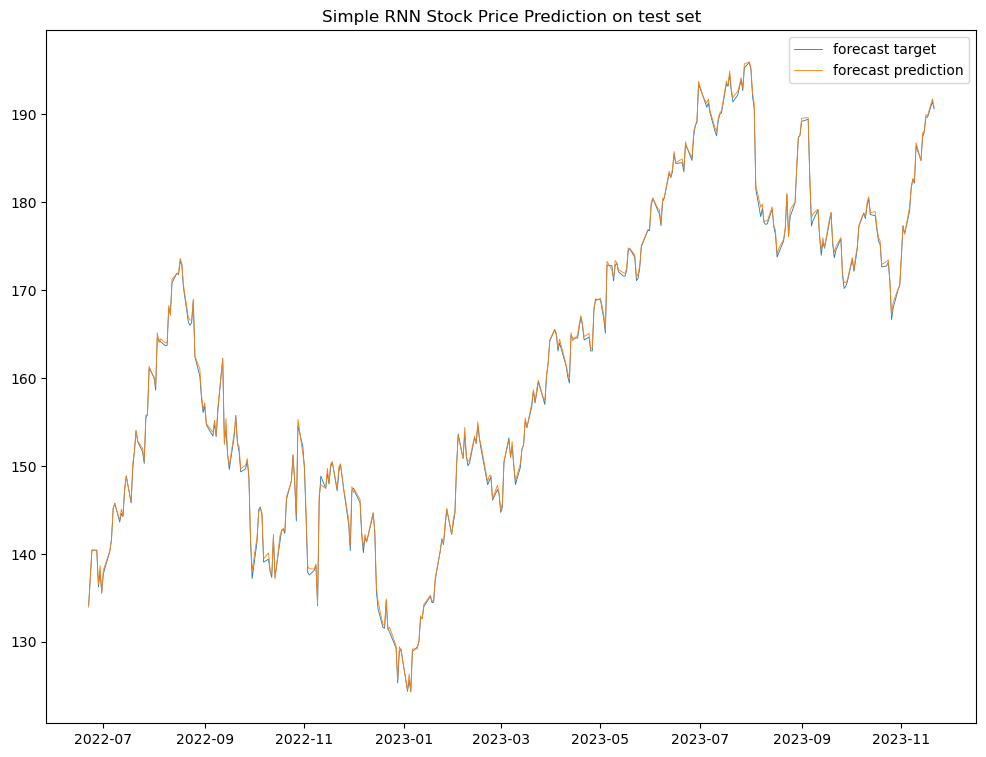

In [25]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-358:] 
plt.plot(AAPL['Adj Close'][-358:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("Simple RNN Stock Price Prediction on test set")
plt.savefig('Simple RNN Stock Price Prediction.png')

## LSTM

In [26]:
class LSTMnetwork(nn.Module):
    
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTMnetwork, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self,X):
        
        # initial hidden states 
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        

        out, _ = self.rnn(X, (h0,c0))
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:,-1,:])
        return out

**One Layer**

In [27]:
# instantiate the model
layer1_lstm_model = LSTMnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=1, n_outputs=1)
layer1_lstm_model 

LSTMnetwork(
  (rnn): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [28]:
count_parameters(layer1_lstm_model)

   200
 10000
   200
   200
    50
     1
______
 10651


In [29]:
layer1_lstm_criterion = nn.MSELoss()
layer1_lstm_optimizer = torch.optim.Adam(layer1_lstm_model.parameters(), lr=0.01)
layer1_lstm_train_losses, layer1_lstm_test_losses = full_gd(layer1_lstm_model,
                                            layer1_lstm_criterion,
                                            layer1_lstm_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0016, Test Loss:0.0014
Epoch 10/100, Train Loss:0.0007, Test Loss:0.0007
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


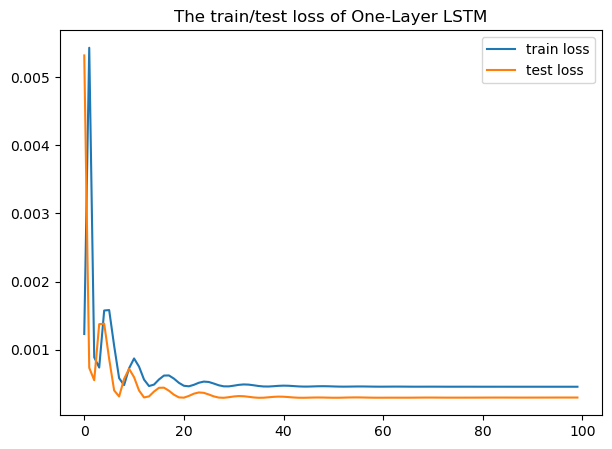

In [30]:
# Plot the train loss and calidation loss per iteration
plt.figure(figsize=(7, 5))
plt.plot(layer1_lstm_train_losses, label="train loss")
plt.plot(layer1_lstm_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of One-Layer LSTM")
plt.savefig('One-Layer LSTM loss.png')

In [31]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer1_lstm_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
    
print("---------------------------------------One-Layer LSTM----------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

---------------------------------------One-Layer LSTM----------------------------------------
Test data RMSE:  0.017226229470185726
Test data MSE:  0.00029674298175949516
Test data MAE:  0.012828487718277696


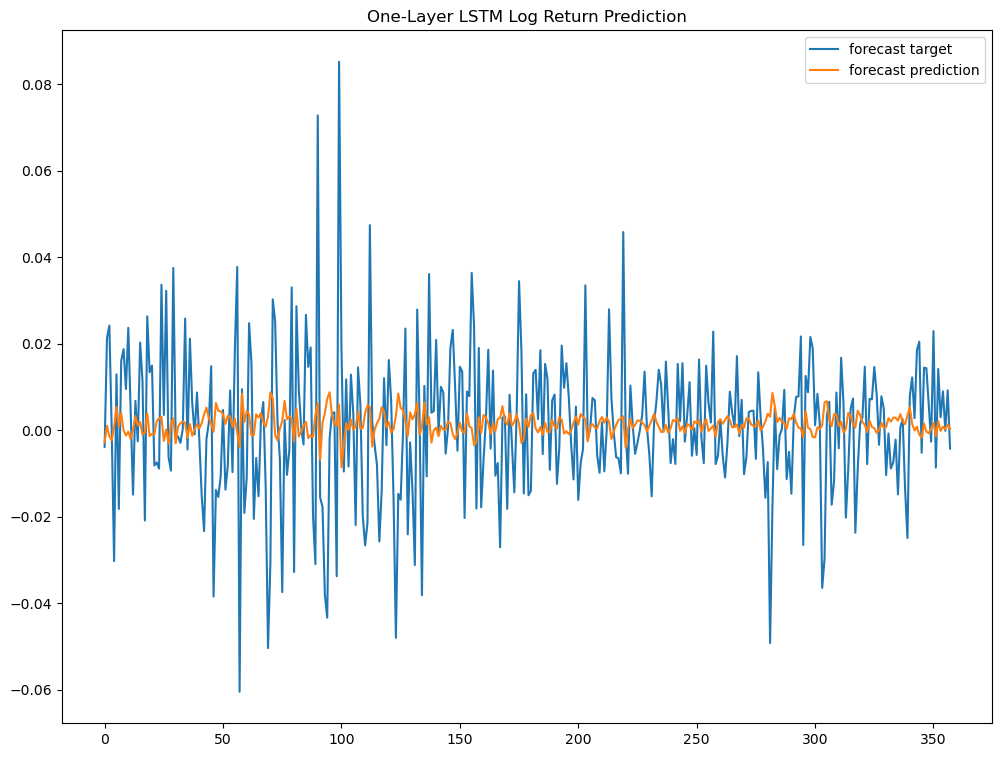

In [32]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("One-Layer LSTM Log Return Prediction")
plt.savefig('One-Layer LSTM Log Return Prediction.png')

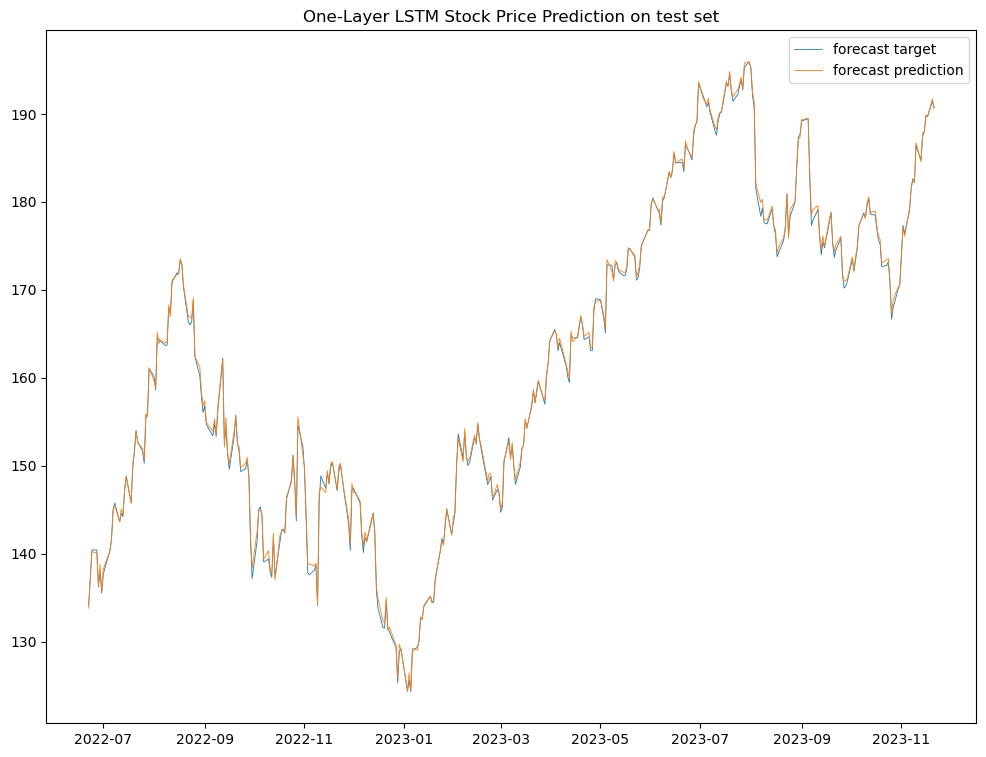

In [33]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-358:] 
plt.plot(AAPL['Adj Close'][-358:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("One-Layer LSTM Stock Price Prediction on test set")
plt.savefig('One-Layer LSTM Stock Price Prediction.png')

**two layer**

In [34]:
# instantiate the model
layer2_lstm_model = LSTMnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=2, n_outputs=1)
layer2_lstm_model 

LSTMnetwork(
  (rnn): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [35]:
count_parameters(layer2_lstm_model)

   200
 10000
   200
   200
 10000
 10000
   200
   200
    50
     1
______
 31051


In [36]:
layer2_lstm_criterion = nn.MSELoss()
layer2_lstm_optimizer = torch.optim.Adam(layer2_lstm_model.parameters(), lr=0.01)
layer2_lstm_train_losses, layer2_lstm_test_losses = full_gd(layer2_lstm_model,
                                            layer2_lstm_criterion,
                                            layer2_lstm_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0042, Test Loss:0.0022
Epoch 10/100, Train Loss:0.0015, Test Loss:0.0012
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


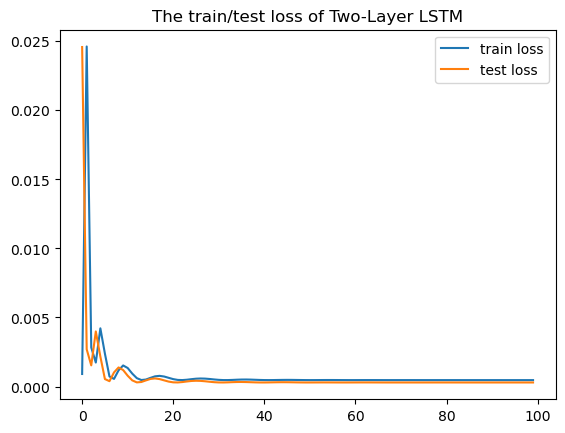

In [37]:
# Plot the train loss and calidation loss per iteration
plt.plot(layer2_lstm_train_losses, label="train loss")
plt.plot(layer2_lstm_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of Two-Layer LSTM")
plt.savefig('Two-Layer LSTM Loss.png')

In [38]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer2_lstm_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
    
print("---------------------------------------Two-Layer LSTM----------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

---------------------------------------Two-Layer LSTM----------------------------------------
Test data RMSE:  0.01710516944768455
Test data MSE:  0.0002925868218340009
Test data MAE:  0.012655572651716518


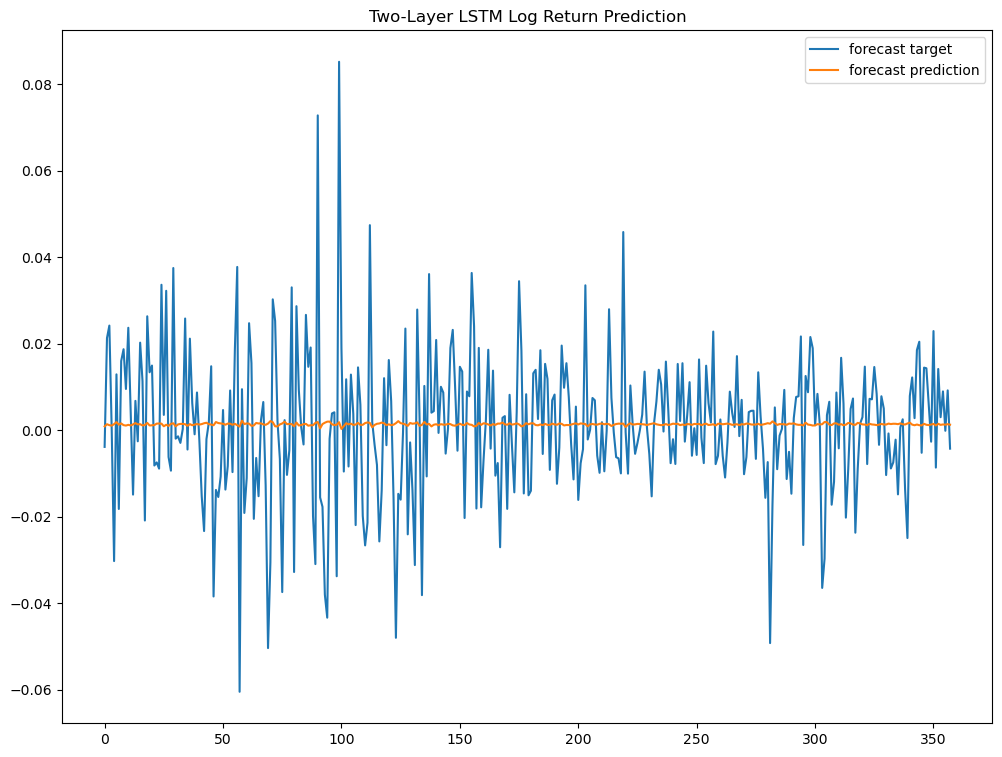

In [39]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("Two-Layer LSTM Log Return Prediction")
plt.savefig('Two-Layer LSTM Log Return Prediction.png')

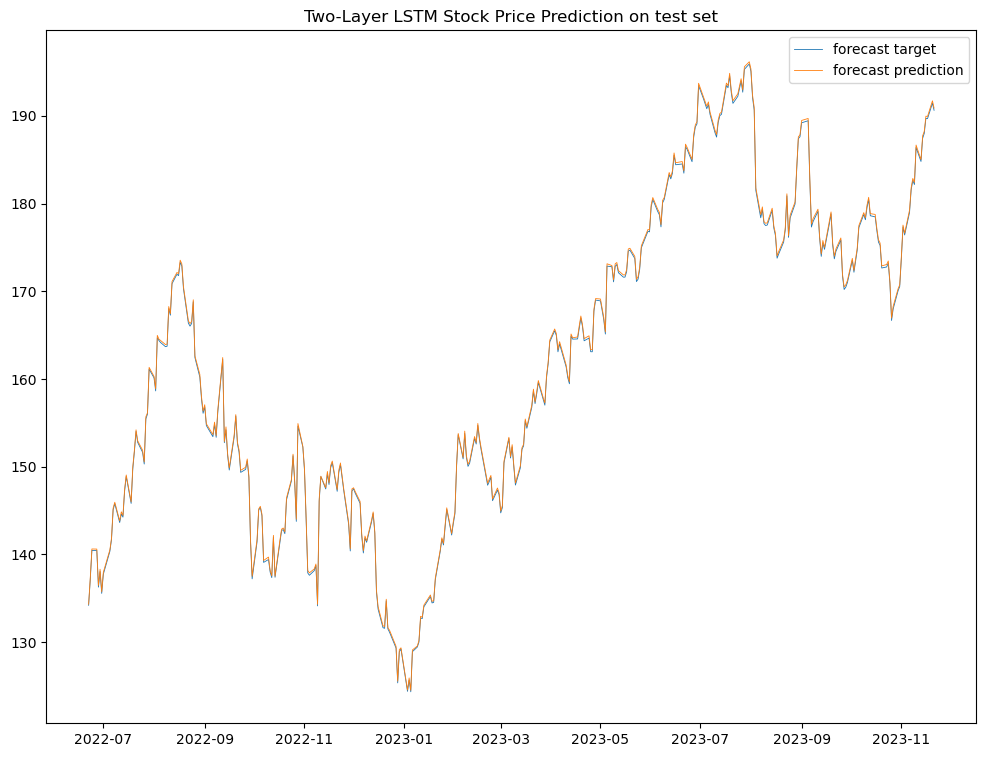

In [40]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-358:] 
plt.plot(AAPL['Adj Close'][-358:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("Two-Layer LSTM Stock Price Prediction on test set")
plt.savefig('Two-Layer LSTM Stock Price Prediction.png')

## GRU

In [41]:
class GRUnetwork(nn.Module):
    
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(GRUnetwork, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.GRU(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self,X):
        
        # initial hidden states 
        
        h0 = torch.zeros(self.L, X.size(0), self.M)
        out, _ = self.rnn(X, h0)
        
        out = self.fc(out[:,-1,:])
        return out

**one layer**

In [42]:
# instantiate the model
layer1_gru_model = GRUnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=1, n_outputs=1)
layer1_gru_model 

GRUnetwork(
  (rnn): GRU(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [43]:
layer1_gru_criterion = nn.MSELoss()
layer1_gru_optimizer = torch.optim.Adam(layer1_gru_model.parameters(), lr=0.01)

In [44]:
count_parameters(layer1_gru_model)

   150
  7500
   150
   150
    50
     1
______
  8001


In [45]:
layer1_gru_train_losses, layer1_gru_test_losses = full_gd(layer1_gru_model,
                                            layer1_gru_criterion,
                                            layer1_gru_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0087, Test Loss:0.0083
Epoch 10/100, Train Loss:0.0010, Test Loss:0.0022
Epoch 15/100, Train Loss:0.0007, Test Loss:0.0003
Epoch 20/100, Train Loss:0.0013, Test Loss:0.0009
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0005
Epoch 30/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


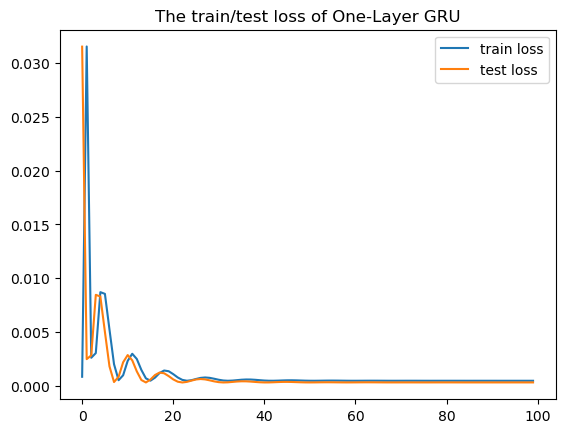

In [46]:
# Plot the train loss and calidation loss per iteration
plt.plot(layer1_gru_train_losses, label="train loss")
plt.plot(layer1_gru_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of One-Layer GRU")
plt.savefig('One-Layer GRU Loss.png')

In [47]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer1_gru_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("----------------------------------One-Layer GRU------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

----------------------------------One-Layer GRU------------------------------------------------
Test data RMSE:  0.017313166896512792
Test data MSE:  0.00029974574798650636
Test data MAE:  0.01293760062694597


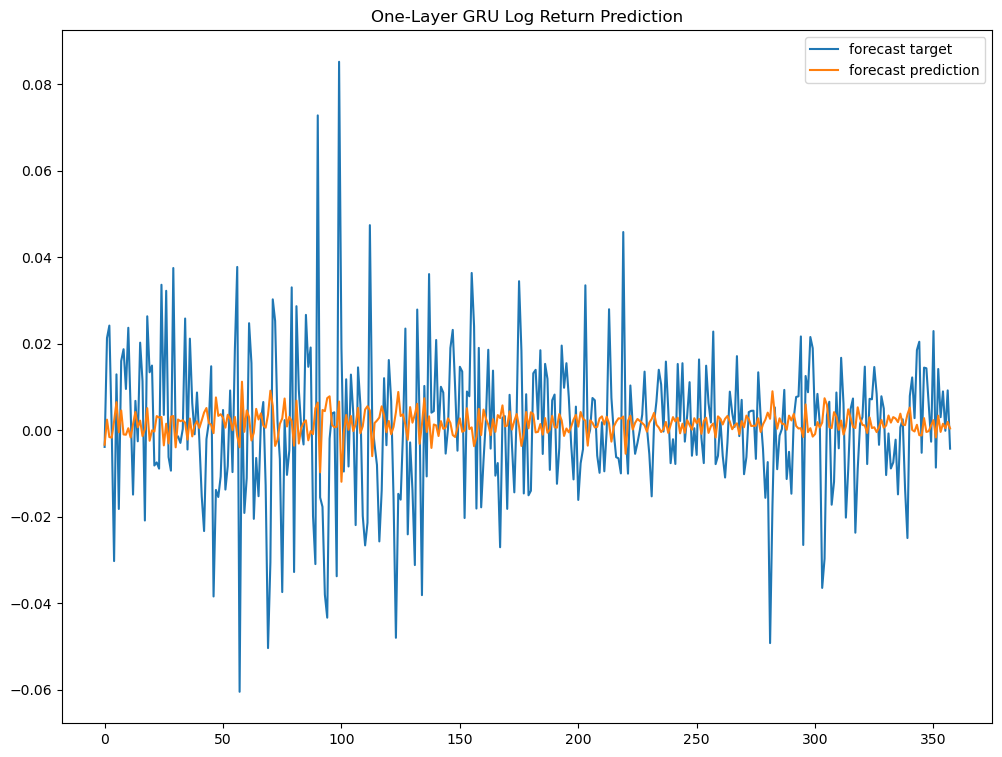

In [48]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("One-Layer GRU Log Return Prediction")
plt.savefig('One-Layer GRU Log Return Prediction.png')

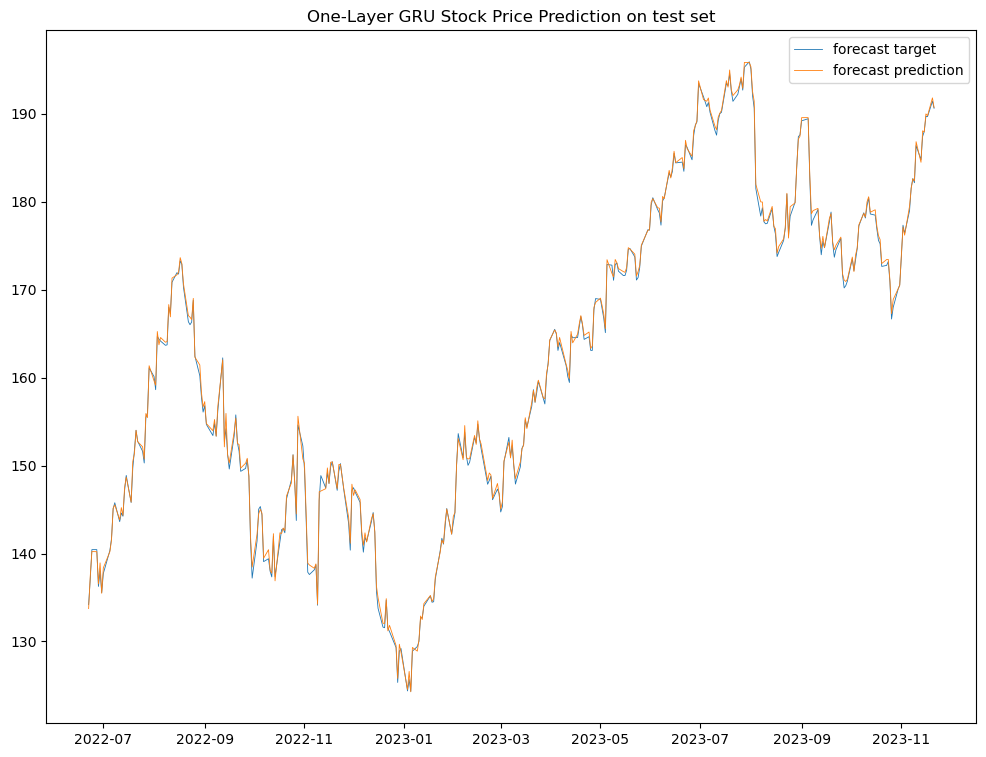

In [49]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-358:] 
plt.plot(AAPL['Adj Close'][-358:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("One-Layer GRU Stock Price Prediction on test set")
plt.savefig('One-Layer GRU Stock Price Prediction.png')

**two layer**

In [50]:
# instantiate the model
layer2_gru_model = GRUnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=2, n_outputs=1)
layer2_gru_model 

GRUnetwork(
  (rnn): GRU(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [51]:
layer2_gru_criterion = nn.MSELoss()
layer2_gru_optimizer = torch.optim.Adam(layer2_gru_model.parameters(), lr=0.01)

In [52]:
count_parameters(layer2_gru_model)

   150
  7500
   150
   150
  7500
  7500
   150
   150
    50
     1
______
 23301


In [53]:
layer2_gru_train_losses, layer2_gru_test_losses = full_gd(layer2_gru_model,
                                            layer2_gru_criterion,
                                            layer2_gru_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0130, Test Loss:0.0114
Epoch 10/100, Train Loss:0.0010, Test Loss:0.0021
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0014, Test Loss:0.0010
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0005
Epoch 30/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


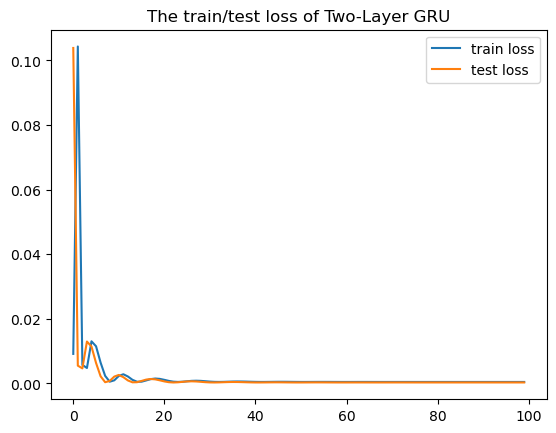

In [54]:
# Plot the train loss and calidation loss per iteration
plt.plot(layer2_gru_train_losses, label="train loss")
plt.plot(layer2_gru_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of Two-Layer GRU")
plt.savefig('Two-Layer GRU Loss.png')

In [55]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer2_gru_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("----------------------------------Two-Layer GRU------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

----------------------------------Two-Layer GRU------------------------------------------------
Test data RMSE:  0.017287791151201826
Test data MSE:  0.0002988677228875722
Test data MAE:  0.012917820696024564


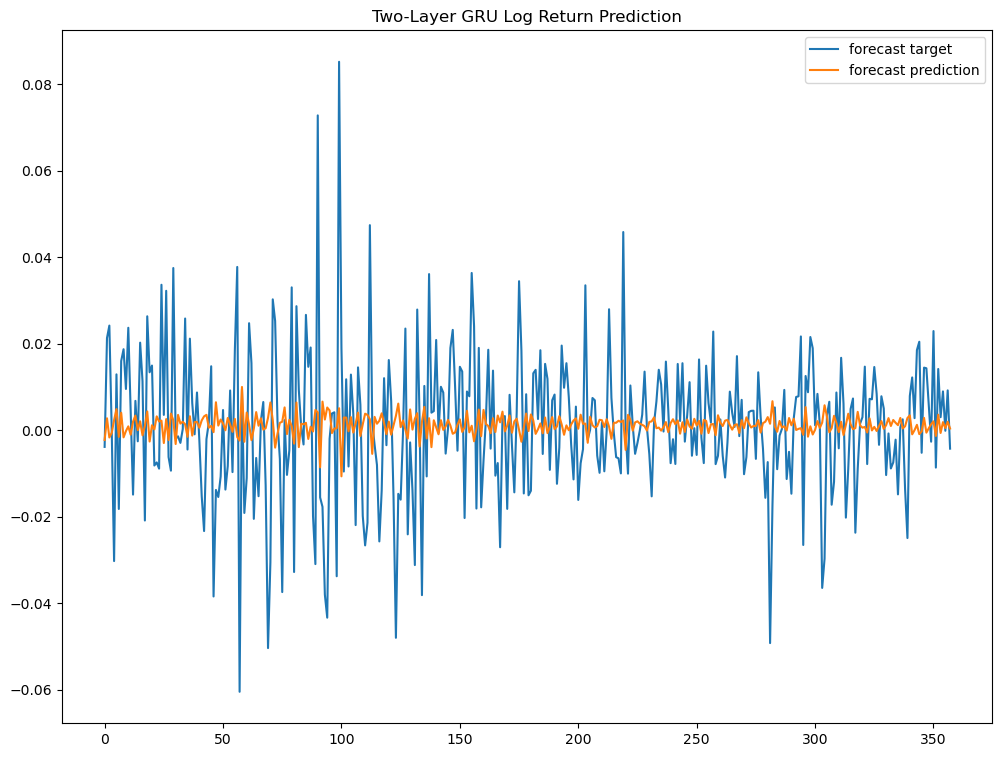

In [56]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("Two-Layer GRU Log Return Prediction")
plt.savefig('Two-Layer GRU Log Return Prediction.png')

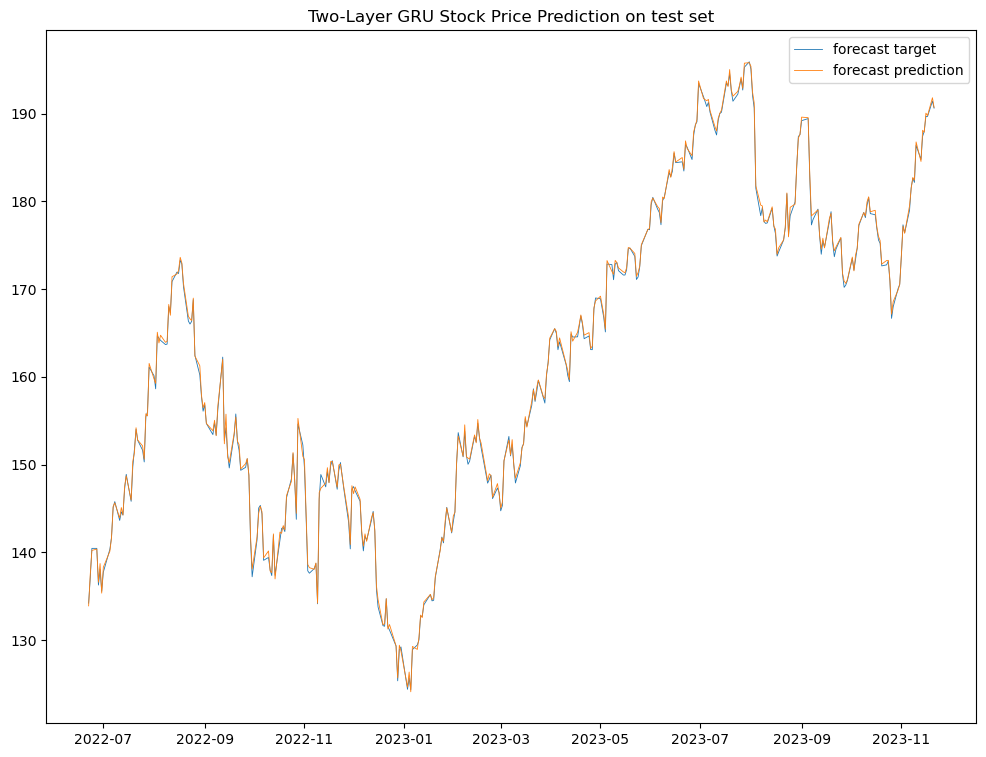

In [57]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-358:] 
plt.plot(AAPL['Adj Close'][-358:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("Two-Layer GRU Stock Price Prediction on test set")
plt.savefig('Two-Layer GRU Stock Price Prediction.png')